In [62]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from miditok import REMI
from miditok.pytorch_data import DatasetMIDI, DataCollator
import numpy as np
# model parameters depend on n_emdb,n_head,n_layer
# hyperparameters
# number of rows of block_size in tensor does not affect # of parameters
# block_size is maximum length of chuncks of characters used in training. It is
# also used when predicting (will never receive more than block_size inputs when
# predicting the next char)
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_song_length = 256
max_iters = 5000
eval_interval = 500
# 1e-04 5e-4 6e-4
learning_rate = 2e-3
# device = 'cuda' if torch.cuda.is_available() else 'mps'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.1
# ------------

torch.manual_seed(1337)



In [63]:
tokenizer = REMI(params=Path("../finalAssignment_musicDataset/tokenizer_432.json"))
vocab_size = tokenizer.vocab_size
midi_paths_train = list(Path(f"../finalAssignment_musicDataset/Token_train_{max_song_length}_432").glob("**/*.mid")) 
midi_paths_valid = list(Path(f"../finalAssignment_musicDataset/Token_valid_{max_song_length}_432").glob("**/*.mid")) 
kwargs_dataset = {"max_seq_len": max_song_length, "tokenizer": tokenizer, "bos_token_id": tokenizer["BOS_None"], "eos_token_id": tokenizer["EOS_None"]}
dataset_train = DatasetMIDI(midi_paths_train, **kwargs_dataset, pre_tokenize=True)
dataset_valid = DatasetMIDI(midi_paths_valid, **kwargs_dataset, pre_tokenize=True)
collator = DataCollator(tokenizer["PAD_None"], copy_inputs_as_labels=True)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collator)
val_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, collate_fn=collator)


Pre-tokenizing: 100%|██████████| 3640/3640 [00:30<00:00, 120.77it/s]


In [64]:


# data loading
def accuracy(prediction, target):
    B, T = prediction.shape
    targets = target.view(B)
    prediction = F.softmax(prediction,dim=-1)\
                .argmax(dim=1)
    scores = (prediction == targets)
    return scores.sum().item() / float(scores.numel())



train_iter = iter(train_loader)
val_iter = iter(val_loader)
def get_batch(split):
    global train_iter, val_iter
    
    data_iter = train_iter if split == 'train' else val_iter
    try:
      batch = next(data_iter)
    except StopIteration:
      if split == 'train':
        train_iter = iter(train_loader)
        batch = next(train_iter)
      else:
        val_iter = iter(val_loader)
        batch = next(val_iter)
    x = batch['input_ids']
    y = x[:, 1:].contiguous()
    x = x[:, :-1].contiguous()  
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {'train': {}, 'val': {}}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
            accuracies[k] = accuracy(logits, Y)
        out[split]['loss'] = losses.mean()
        out[split]['acc'] = accuracies.mean()
    model.train()
    return out




tensor([  3, 431, 140, 403,  54, 112, 127, 146,  50, 112, 127, 152,  52, 112,
        127, 158,  47, 112, 124, 161,  45, 112, 130, 176,  54, 106, 125, 180,
         54, 106, 125, 184,  54, 106, 125,   3, 431, 140,  52, 106, 127, 146,
         50, 106, 127, 152,  54, 106, 127, 158,  52, 106, 124, 161,  54, 106,
        124, 164,  52, 106, 129, 176,  54, 106, 125, 180,  54, 106, 125, 184,
         54, 106, 125,   3, 431, 140,  52, 106, 127, 146,  50, 106, 127, 152,
         54, 106, 127, 158,  52, 106, 124, 161,  50, 106, 124, 164,  54, 106,
        127, 170,  52, 106, 124, 173,  50, 106, 124, 176,  54, 106, 125, 180,
         54, 106, 125, 184,  54, 106, 125,   3, 431, 140,  52, 106, 127, 146,
         50, 106, 127, 152,  54, 106, 127, 158,  57, 106, 124, 161,  54, 106,
        124, 164,  52, 106, 132, 371, 176,  54, 106, 125, 180,  54, 106, 125,
        184,  54, 106, 125,   3, 431, 140,  52, 106, 127, 146,  50, 106, 127,
        152,  54, 106, 124, 155,  52, 106, 124, 158,  50, 106, 1

In [65]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [66]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


In [67]:
import math

class RelativeGlobalAttention(nn.Module):
    def __init__(self, head_dim, n_head, dropout, device, max_len=max_song_length):
        super().__init__()
        
        d_head, _ = divmod(n_embd, n_head)
        self.hid_dim = n_embd
        self.n_heads = n_head
        self.head_dim = head_dim 
        self.max_relative_position = max_len

        self.key = nn.Linear(self.hid_dim, self.hid_dim)
        self.query = nn.Linear(self.hid_dim, self.hid_dim)
        self.value = nn.Linear(self.hid_dim, self.hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.Er = nn.Parameter(torch.randn(self.max_relative_position, d_head))
        self.register_buffer(
            "mask", 
            torch.tril(torch.ones(self.max_relative_position, self.max_relative_position))
            .unsqueeze(0).unsqueeze(0)
        )
        
    def forward(self, x, mask = None):
        batch_size, seq_len, _ = x.shape
        
        if seq_len > self.max_relative_position:
            print(f"sequence length {seq_len} exceeds model capacity {self.max_relative_position}")
        k_t = self.key(x).reshape(batch_size, seq_len, self.n_heads, -1).permute(0, 2, 3, 1)
        # k_t.shape = (batch_size, num_heads, d_head, seq_len)
        v = self.value(x).reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        # shape = (batch_size, num_heads, seq_len, d_head)
        
        start = self.max_relative_position - seq_len
        Er_t = self.Er[start:, :].transpose(0, 1)
        # Er_t.shape = (d_head, seq_len)
        QEr = torch.matmul(q, Er_t)
        # QEr.shape = (batch_size, num_heads, seq_len, seq_len)
        Srel = self.skew(QEr)
        # Srel.shape = (batch_size, num_heads, seq_len, seq_len)
        
        QK_t = torch.matmul(q, k_t)
        # QK_t.shape = (batch_size, num_heads, seq_len, seq_len)
        attn = (QK_t + Srel) / math.sqrt(q.size(-1))
        mask = self.mask[:, :, :seq_len, :seq_len]
        # mask.shape = (1, 1, seq_len, seq_len)
        attn = attn.masked_fill(mask == 0, float("-inf"))
        # attn.shape = (batch_size, num_heads, seq_len, seq_len)
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)
        # out.shape = (batch_size, num_heads, seq_len, d_head)
        out = out.transpose(1, 2)
        # out.shape == (batch_size, seq_len, num_heads, d_head)
        out = out.reshape(batch_size, seq_len, -1)
        # out.shape == (batch_size, seq_len, d_model)
        return self.dropout(out)
        
    
    def skew(self, QEr):
        # QEr.shape = (batch_size, num_heads, seq_len, seq_len)
        padded = F.pad(QEr, (1, 0))
        # padded.shape = (batch_size, num_heads, seq_len, 1 + seq_len)
        batch_size, num_heads, num_rows, num_cols = padded.shape
        reshaped = padded.reshape(batch_size, num_heads, num_cols, num_rows)
        # reshaped.size = (batch_size, num_heads, 1 + seq_len, seq_len)
        Srel = reshaped[:, :, 1:, :]
        # Srel.shape = (batch_size, num_heads, seq_len, seq_len)
        return Srel

In [68]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


In [69]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        # self.sa = MultiHeadAttention(n_head, head_size)
        self.sa = RelativeGlobalAttention(head_size, n_head, dropout, device)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [70]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.drop = nn.Dropout(dropout)
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = self.drop(tok_emb + pos_emb) # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [71]:
'''A wrapper class for scheduled optimizer '''

class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr


0.903856 M parameters
step 0: train loss 6.0672, train accuracy 0.0019, val loss 6.0671, val accuracy 0.0023
step 500: train loss 0.9488, train accuracy 0.7053, val loss 0.9187, val accuracy 0.7165
step 1000: train loss 0.8280, train accuracy 0.7341, val loss 0.8058, val accuracy 0.7431
step 1500: train loss 0.7883, train accuracy 0.7433, val loss 0.7638, val accuracy 0.7532
step 2000: train loss 0.7649, train accuracy 0.7490, val loss 0.7426, val accuracy 0.7572
step 2500: train loss 0.7465, train accuracy 0.7544, val loss 0.7254, val accuracy 0.7619
step 3000: train loss 0.7323, train accuracy 0.7583, val loss 0.7134, val accuracy 0.7659
step 3500: train loss 0.7056, train accuracy 0.7667, val loss 0.6962, val accuracy 0.7707
step 4000: train loss 0.6969, train accuracy 0.7706, val loss 0.6881, val accuracy 0.7735
step 4500: train loss 0.6842, train accuracy 0.7738, val loss 0.6752, val accuracy 0.7788
step 4999: train loss 0.6776, train accuracy 0.7764, val loss 0.6633, val accuracy

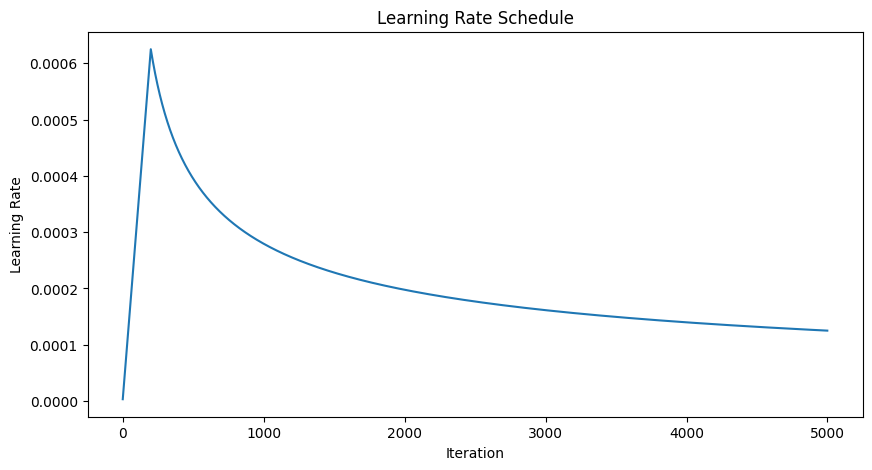

In [72]:
model = GPTLanguageModel()
# model.load_state_dict(torch.load("./model/music_20250104-162131.pth", weights_only=True))
# model.eval()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# # create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9,0.98),eps=1e-9)
scheduled_optimizer = ScheduledOptim(optimizer, 0.1, n_embd, 200)
train_loss = []
val_loss = []
learning_rates = []

for i in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if i % eval_interval == 0 or i == max_iters - 1:
        losses = estimate_loss()
        train_loss.append(losses['train']['loss'])
        val_loss.append(losses['val']['loss'])
        print(f"step {i}: train loss {losses['train']['loss']:.4f}, "
              f"train accuracy {losses['train']['acc']:.4f}, "
              f"val loss {losses['val']['loss']:.4f}, "
              f"val accuracy {losses['val']['acc']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    scheduled_optimizer.zero_grad()
    loss.backward()
    scheduled_optimizer.step_and_update_lr()

    # record the learning rate
    learning_rates.append(scheduled_optimizer._optimizer.param_groups[0]['lr'])

# generate from the model

# Generate x-axis values
steps = list(range(0, max_iters + 1, eval_interval))

# Plot the learning rates
plt.figure(figsize=(10, 5))
plt.plot(learning_rates)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()



In [90]:
from copy import deepcopy

x, y = get_batch('val')
count = 1           
continuation = m.generate(x, 512)[0]
generated = continuation[len(x[0]):]
midi = tokenizer.decode([deepcopy(generated.tolist())])
tokens = [generated, x[0], continuation]  # list compr. as seqs of dif. lengths
tokens = [seq.tolist() for seq in tokens]
for tok_seq in tokens[1:]:
    _midi = tokenizer.decode([deepcopy(tok_seq)])
    midi.tracks.append(_midi.tracks[0])
midi.tracks[0].name = f'Continuation of original sample ({len(generated)} tokens)'
midi.tracks[1].name = f'Original sample ({len(x[0])} tokens)'
midi.dump_midi(Path(f'./midi_files/') / f'{count}.mid')
tokenizer.save_tokens(tokens, Path(f'./midi_files/')  / f'{count}.json') 
print(midi)

Score(ttype=Tick, tpq=24, begin=0, end=1796, tracks=3, notes=152, time_sig=1, key_sig=0, markers=0)


In [92]:
count = 2
midi = tokenizer.decode([deepcopy(generated.tolist())])
midi.dump_midi(Path(f'./midi_files/') / f'{count}.mid')
tokenizer.save_tokens(tokens, Path(f'./midi_files/')  / f'{count}.json') 
print(midi)

Score(ttype=Tick, tpq=24, begin=0, end=356, tracks=1, notes=18, time_sig=1, key_sig=0, markers=0)


In [94]:


def visualize_midi(midi_path, sampling_rate=16000, seconds=15, out_dir=None):
    import pretty_midi
    from scipy.io.wavfile import write as write_wav
    from IPython.display import Audio
    import os
    from os import path

    # Create the audio waveform
    pretty_midi_file = pretty_midi.PrettyMIDI(midi_path)
    waveform = pretty_midi_file.fluidsynth(fs=sampling_rate)[: seconds * sampling_rate]

    # Display the audio if no path is provided
    if out_dir is None:
        # IPython display
        return Audio(waveform, rate=sampling_rate)

    # Save the audio to a file
    os.makedirs(out_dir, exist_ok=True)
    audio_path = path.join(out_dir, path.basename(midi_path).split(".")[0] + ".wav")
    write_wav(audio_path, sampling_rate, (waveform * 32767).astype(np.int16))
    return audio_path

visualize_midi("./midi_files/1.mid", out_dir="./")
visualize_midi("./midi_files/2.mid", out_dir="./")

'./2.wav'

In [95]:
visualize_midi("./midi_files/gen1.mid", out_dir="./")

'./gen1.wav'

In [82]:
class BaselineLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

dummy = BaselineLanguageModel(tokenizer.vocab_size)
d = dummy.to(device)
xb, xy = get_batch("train")
logits, loss = dummy(xb, xy)
acc = accuracy(logits, xy)
print(f"Dummy model: loss {loss:.4f}, "
              f"accuracy {acc:.4f}, ")
continuation = dummy.generate(x, 256)[0]
generated = continuation[len(x[0]):]
midi = tokenizer.decode([deepcopy(generated.tolist())])
midi.dump_midi(Path(f'./midi_files/') / f'dummy.mid')
tokenizer.save_tokens(tokens, Path(f'./midi_files/')  / f'dummy.json') 
print(midi)
visualize_midi("./midi_files/dummy.mid", out_dir="./")


Dummy model: loss 6.5906, accuracy 0.0040, 
Score(ttype=Tick, tpq=24, begin=0, end=1405, tracks=1, notes=1, time_sig=5, key_sig=0, markers=0)


'./dummy.wav'

In [80]:
import time

timestamp = time.strftime("%Y%m%d-%H%M%S")
model_name = f"./model/music_{timestamp}.pth"
torch.save(model.state_dict(), model_name)